Comparison of Convolutional Neural Networks for Binary Classification of HER2 Status in Breast Cancer <br>
m-wynes


In [1]:
# Import libraries
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [2]:
# Define dataset

class HER2ExpressionDataset(Dataset):
    def __init__(self, img_dir, transform = None, binary = True): 
        self.img_dir = img_dir
        self.transform = transform
        self.binary = binary # sets binary classification
        self.img_paths = [f for f in os.listdir(img_dir) if f.endswith(".png")]
    
    def __len__(self):
        return len(self.img_paths)
    
    # parsing labels
    def _parse_label(self, filename):
        label_str = filename.split("_")[-1].replace(".png", "")
        
        if self.binary: # 0 & +1 = HER2 negative, 2+ & 3+ = HER2 positive
            if label_str in ["0", "1+"]:
                return 0 # low HER2 expression 
            elif label_str in ["2+", "3+"]:
                return 1 # high HER2 expression
            else:
                raise ValueError(f"Unknown HER2 expression level: {label_str}")
        # If binary classification is false:
        else: 
            label_map = {'0': 0, '1+': 1, '2+': 2, '3+': 3}
            return label_map.get(label_str, -1)
    
    # loading each image
    def __getitem__(self, idx):
        img_name = self.img_paths[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        image = Image.open(img_path).convert("RGB")
        label = self._parse_label(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
# Training and Testing set directories
training_directory = "BCI_dataset/IHC/train"

testing_directory = "BCI_dataset/IHC/test"

In [4]:
# Checking that the images are accessible 
print(os.listdir(training_directory)[:5])

print(os.listdir(testing_directory)[:5])

['00000_train_1+.png', '00001_train_3+.png', '00002_train_3+.png', '00003_train_1+.png', '00004_train_1+.png']
['00000_test_1+.png', '00001_test_2+.png', '00002_test_2+.png', '00003_test_3+.png', '00004_test_0.png']


In [5]:
# Transofrm images to 299 x 299
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

In [6]:
# Load datasets
training_dataset = HER2ExpressionDataset(img_dir = training_directory, transform = transform, binary = True)

testing_dataset = HER2ExpressionDataset(img_dir = testing_directory, transform = transform, binary = True)

training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

testing_loader = DataLoader(testing_dataset, batch_size=32, shuffle=True)

In [7]:
n_epochs = 20
batch_size = 32

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Counting positive and negative samples to determine class distribution

from collections import Counter

labels = [training_dataset._parse_label(fname) for fname in training_dataset.img_paths]
print("Class distribution:", Counter(labels))

# Weight formula
pos_count = 2775
neg_count = 1121
pos_weight = torch.tensor([1.0 / (pos_count / (pos_count + neg_count))]).to(device)

Class distribution: Counter({1: 2775, 0: 1121})


In [ ]:
# Define the validation dataset size 
val_size = int(0.2 * len(training_dataset)) # 20% of training data
train_size = len(training_dataset) - val_size 

train_data, val_data = random_split(training_dataset, [train_size, val_size])

# DataLoader creation
train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0,
)

val_loader = DataLoader(
    val_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0,
)

test_loader = DataLoader(
    testing_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0,
)

LeNet-Based Model

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  

            nn.Conv2d(6, 16, kernel_size = 5),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)  
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),  
            nn.Linear(16 * 72 * 72, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 1), 
            
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [15]:
LeNetmodel = LeNet().to(device)
print(LeNetmodel)

LeNet(
  (conv_layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=82944, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=1, bias=True)
  )
)


In [16]:
LeNetmodel.train()

optimizer = torch.optim.Adam(LeNetmodel.parameters(), lr = 0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

# Training loop
losses = []
for epoch in range(n_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = LeNetmodel(images)
        loss = loss_fn(predictions, labels.float().view(-1, 1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Report epochs
    avg_loss = running_loss / len(training_loader)
    losses.append(avg_loss)  # append only one value per epoch
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.5492
Epoch 2/20, Loss: 0.5122
Epoch 3/20, Loss: 0.4997
Epoch 4/20, Loss: 0.4890
Epoch 5/20, Loss: 0.4842
Epoch 6/20, Loss: 0.4892
Epoch 7/20, Loss: 0.4780
Epoch 8/20, Loss: 0.4724
Epoch 9/20, Loss: 0.4675
Epoch 10/20, Loss: 0.4681
Epoch 11/20, Loss: 0.4612
Epoch 12/20, Loss: 0.4551
Epoch 13/20, Loss: 0.4535
Epoch 14/20, Loss: 0.4478
Epoch 15/20, Loss: 0.4472
Epoch 16/20, Loss: 0.4429
Epoch 17/20, Loss: 0.4367
Epoch 18/20, Loss: 0.4260
Epoch 19/20, Loss: 0.4132
Epoch 20/20, Loss: 0.4023


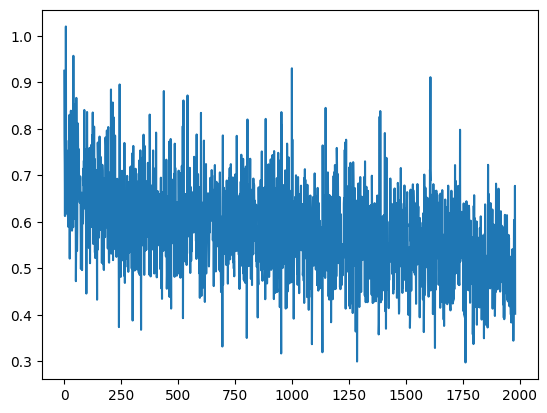

In [17]:
# Loss Plot

fig, ax = plt.subplots()
ax.plot(losses)

In [18]:
LeNetmodel.eval()


# Training evaluation
y = []
yhat = []
for images, labels in train_loader:
    images = images.to(device).float()
    labels = labels.cpu().numpy().tolist()
    predictions = LeNetmodel(images).cpu().detach().numpy().tolist()

    y.extend(labels)
    yhat.extend(predictions)

print("train")
print("accuracy =", accuracy_score(y, np.array(yhat) > 0.5))
print("precision =", precision_score(y, np.array(yhat) > 0.5))
print("recall =", recall_score(y, np.array(yhat) > 0.5))
print("roc auc =", roc_auc_score(y, yhat))

# Validation evaluation
y = []
yhat = []
for images, labels in val_loader:
    images = images.to(device).float()
    labels = labels.cpu().numpy().tolist()
    predictions = LeNetmodel(images).cpu().detach().numpy().tolist()

    y.extend(labels)
    yhat.extend(predictions)

print("\nvalidation")
print("accuracy =", accuracy_score(y, np.array(yhat) > 0.5))
print("precision =", precision_score(y, np.array(yhat) > 0.5))
print("recall =", recall_score(y, np.array(yhat) > 0.5))
print("roc auc =", roc_auc_score(y, yhat))

train
accuracy = 0.8312479948668592
precision = 0.9464004203888597
recall = 0.809438202247191
roc auc = 0.9399077946289112

validation
accuracy = 0.7060333761232349
precision = 0.8378947368421052
recall = 0.7236363636363636
roc auc = 0.778356490670901


AlexNet-Based Model

In [ ]:
class AlexNet_model(nn.Module):
    def __init__(self):
        super(AlexNet_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2),  
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),  
            
            nn.Conv2d(64, 192, kernel_size = 5, padding = 2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),  
            
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),  
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),  
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),  
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2)  
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 8 * 8, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1)  
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x 

In [20]:
alexnet_model = AlexNet_model().to(device)
print(alexnet_model)

AlexNet_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=16384, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(

In [21]:
alexnet_model.train()

optimizer = torch.optim.Adam(alexnet_model.parameters(), lr=0.00001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

# Training loop
losses = []
for epoch in range(n_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = alexnet_model(images)
        loss = loss_fn(predictions, labels.float().view(-1, 1))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Report epochs
    avg_loss = running_loss / len(training_loader)
    losses.append(avg_loss)  # append only one value per epoch
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.5771
Epoch 2/20, Loss: 0.5130
Epoch 3/20, Loss: 0.4698
Epoch 4/20, Loss: 0.4668
Epoch 5/20, Loss: 0.4650
Epoch 6/20, Loss: 0.4599
Epoch 7/20, Loss: 0.4648
Epoch 8/20, Loss: 0.4560
Epoch 9/20, Loss: 0.4577
Epoch 10/20, Loss: 0.4581
Epoch 11/20, Loss: 0.4528
Epoch 12/20, Loss: 0.4566
Epoch 13/20, Loss: 0.4531
Epoch 14/20, Loss: 0.4505
Epoch 15/20, Loss: 0.4528
Epoch 16/20, Loss: 0.4533
Epoch 17/20, Loss: 0.4485
Epoch 18/20, Loss: 0.4502
Epoch 19/20, Loss: 0.4499
Epoch 20/20, Loss: 0.4450


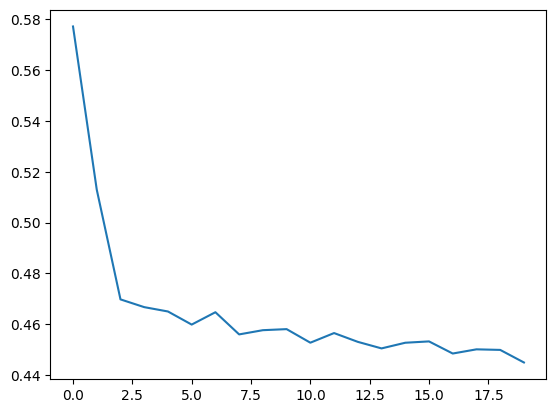

In [22]:
fig, ax = plt.subplots()
ax.plot(losses)

In [23]:
alexnet_model.eval()


# Training evaluation
y = []
yhat = []
for images, labels in train_loader:
    images = images.to(device).float()
    labels = labels.cpu().numpy().tolist()
    predictions = alexnet_model(images).cpu().detach().numpy().tolist()

    y.extend(labels)
    yhat.extend(predictions)

print("train")
print("accuracy =", accuracy_score(y, np.array(yhat) > 0.5))
print("precision =", precision_score(y, np.array(yhat) > 0.5))
print("recall =", recall_score(y, np.array(yhat) > 0.5))
print("roc auc =", roc_auc_score(y, yhat))

# Validation evaluation
y = []
yhat = []
for images, labels in val_loader:
    images = images.to(device).float()
    labels = labels.cpu().numpy().tolist()
    predictions = alexnet_model(images).cpu().detach().numpy().tolist()

    y.extend(labels)
    yhat.extend(predictions)

print("\nvalidation")
print("accuracy =", accuracy_score(y, np.array(yhat) > 0.5))
print("precision =", precision_score(y, np.array(yhat) > 0.5))
print("recall =", recall_score(y, np.array(yhat) > 0.5))
print("roc auc =", roc_auc_score(y, yhat))

train
accuracy = 0.712864934231633
precision = 0.7873811581676751
recall = 0.818876404494382
roc auc = 0.7692608454678288

validation
accuracy = 0.7098844672657253
precision = 0.78125
recall = 0.8181818181818182
roc auc = 0.7762445414847161


miniHAHNet with Inception Block Model

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, 32, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 48, kernel_size = 3, padding = 1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(16, 24, kernel_size = 5, padding = 2)
        )

        # 3x3 maxpool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_channels, 16, kernel_size = 1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim = 1)
        return outputs

class MiniHAHNet(nn.Module):
    def __init__(self):
        super(MiniHAHNet, self).__init__()
        self.inception = InceptionBlock(in_channels = 3)  

        self.features = nn.Sequential(
            nn.Conv2d(120, 64, kernel_size=3, padding = 1),  # 120 channels from Inception output
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 74 * 74, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(512, 1)  # Binary classification
        )

    def forward(self, x):
        x = self.inception(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [14]:
miniHAHNet_model = MiniHAHNet().to(device)
print(miniHAHNet_model)

MiniHAHNet(
  (inception): InceptionBlock(
    (branch1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (branch3): Sequential(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (branch4): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (features): Sequential(
    (0): Conv2d(120, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplac

In [15]:
miniHAHNet_model.train()

optimizer = torch.optim.Adam(miniHAHNet_model.parameters(), lr=0.00001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

losses = []
for epoch in range(n_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = miniHAHNet_model(images)
        loss = loss_fn(predictions, labels.float().view(-1, 1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Report epochs
    avg_loss = running_loss / len(training_loader)
    losses.append(avg_loss)  # append only one value per epoch
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.5471
Epoch 2/20, Loss: 0.5196
Epoch 3/20, Loss: 0.5117
Epoch 4/20, Loss: 0.4999
Epoch 5/20, Loss: 0.4943
Epoch 6/20, Loss: 0.4849
Epoch 7/20, Loss: 0.4820
Epoch 8/20, Loss: 0.4729
Epoch 9/20, Loss: 0.4742
Epoch 10/20, Loss: 0.4689
Epoch 11/20, Loss: 0.4649
Epoch 12/20, Loss: 0.4629
Epoch 13/20, Loss: 0.4573
Epoch 14/20, Loss: 0.4552
Epoch 15/20, Loss: 0.4538
Epoch 16/20, Loss: 0.4467
Epoch 17/20, Loss: 0.4503
Epoch 18/20, Loss: 0.4508
Epoch 19/20, Loss: 0.4438
Epoch 20/20, Loss: 0.4417


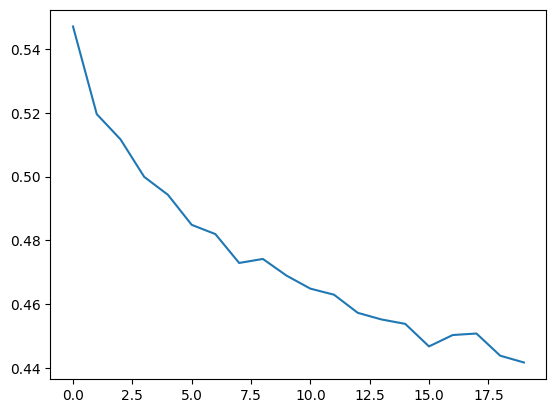

In [16]:
fig, ax = plt.subplots()
ax.plot(losses)

In [17]:
miniHAHNet_model.eval()


# Training evaluation
y = []
yhat = []
for images, labels in train_loader:
    images = images.to(device).float()
    labels = labels.cpu().numpy().tolist()
    predictions = miniHAHNet_model(images).cpu().detach().numpy().tolist()

    y.extend(labels)
    yhat.extend(predictions)

print("train")
print("accuracy =", accuracy_score(y, np.array(yhat) > 0.5))
print("precision =", precision_score(y, np.array(yhat) > 0.5))
print("recall =", recall_score(y, np.array(yhat) > 0.5))
print("roc auc =", roc_auc_score(y, yhat))

# Validation evaluation
y = []
yhat = []
for images, labels in val_loader:
    images = images.to(device).float()
    labels = labels.cpu().numpy().tolist()
    predictions = miniHAHNet_model(images).cpu().detach().numpy().tolist()

    y.extend(labels)
    yhat.extend(predictions)

print("\nvalidation")
print("accuracy =", accuracy_score(y, np.array(yhat) > 0.5))
print("precision =", precision_score(y, np.array(yhat) > 0.5))
print("recall =", recall_score(y, np.array(yhat) > 0.5))
print("roc auc =", roc_auc_score(y, yhat))

train
accuracy = 0.7189605389797883
precision = 0.7188216039279869
recall = 0.9923181201988251
roc auc = 0.807777553395263

validation
accuracy = 0.72400513478819
precision = 0.726797385620915
recall = 0.9893238434163701
roc auc = 0.8188989291044164
